## Background for Autokeras

There are several ways for hyper-parameter searching:

### Grid Search: 

**1. what:** divide each parameter's valid range into evenly spaced values, and then simply have the computer try all combinations of parameter-values

**2. cons:** time-consuming and leads to curse of dimensionality as there are usually a lot of hyper-parameters to tune


### Hand Tuning: 

**1. what:** based on trying and error and observation to build sense about hyper-parameters

**2. cons:** the optimal hyper-parameters may be counter-intuitive, and could not be approached by this way


---


---




**Autokeras **is leveraging a method called **Bayesian Optimization**, which balanced the exploration of the whole space for hyper-parameters, and exploitation of the promising regions where there are better performance

![](https://github.com/Hvass-Labs/TensorFlow-Tutorials/raw/aa0d6796c6bb61a4c81ab1f8d0dc425cc034095e/images/19_flowchart_bayesian_optimization.png)
*This chart is referenced from: [source](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/19_Hyper-Parameters.ipynb)*

### Bayesian Optimization:

**1. what:** construct another model (guassian process) to estimate the distribution of the performance varies with changes to the hyper-parameters. 

**2. concept: **similar input produce similar output

**3. strategy: **

>* **phase 1: exploration - seek places with high variance**

>* **phase 2: exploitation - focus on the promising area**


## 1.  Install Autokeras and Import Needed Libraries

*[Library link:](https://autokeras.com/)*

*[Source Code:](https://github.com/jhfjhfj1/autokeras:)*

*Note: currently, Auto-Keras is only compatible with: Python 3.6*

In [28]:
! pip install autokeras

  Using cached https://files.pythonhosted.org/packages/85/5e/e91792f198bbc5a0d7d3055ad552bc4062942d27eaf75c3e2783cf64eae5/Pillow-5.4.1-cp36-cp36m-manylinux1_x86_64.whl
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [29]:
# autokeras
import autokeras as ak
from autokeras.nn.metric import Accuracy
from autokeras.image.image_supervised import load_image_dataset, ImageClassifier

# keras
from keras.models import load_model
from keras.utils import plot_model


# general

import zipfile
import os
import csv
import shutil


# colab always report error with PIL, reinstall it to avoid the error
!pip install Pillow==4.0.0
!pip install PIL
!pip install image
import PIL

  Using cached https://files.pythonhosted.org/packages/37/e8/b3fbf87b0188d22246678f8cd61e23e31caa1769ebc06f1664e2e5fe8a17/Pillow-4.0.0-cp36-cp36m-manylinux1_x86_64.whl
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
scikit-image 0.14.2 has requirement pillow>=4.3.0, but you'll have pillow 4.0.0 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: Pillow 5.4.1
    Uninstalling Pillow-5.4.1:
      Successfully uninstalled Pillow-5.4.1


  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL


## 2. Prepare the Data

###1. Resize the data to 32 X 32

This functions helps resize data

In [0]:
# alg_dict = {
#     'lanczos': Image.LANCZOS,
#     'nearest': Image.NEAREST,
#     'bilinear': Image.BILINEAR,
#     'bicubic': Image.BICUBIC,
#     'hamming': Image.HAMMING,
#     'box': Image.BOX
# }

# def str2alg(str):
#     str = str.lower()
#     return alg_dict.get(str, None)

# # Takes in_dir, out_dir and alg as strings
# # resize images from in_dir using algorithm deduced from
# # alg string and puts them to "out_dir/alg/" folder
# def resize_img_folder(in_dir, out_dir, alg = 'box', size):
#     print('Folder %s' % in_dir)

#     alg_val = str2alg(alg)

#     if alg_val is None:
#         print("Sorry but this algorithm (%s) is not available, use help for more info." % alg)
#         return

#     if not os.path.exists(out_dir):
#         os.makedirs(out_dir)

#     for filename in os.listdir(in_dir):
#         # Exception raised when file is not an image
#         try:
#             im = Image.open(os.path.join(in_dir, str(filename)))

#             # Convert grayscale images into 3 channels
#             if im.mode != "RGB":
#                 im = im.convert(mode="RGB")

#             im_resized = im.resize((size, size), alg_val)
#             # Get rid of extension (.jpg or other)
#             filename = os.path.splitext(filename)[0]
#             im_resized.save(os.path.join(out_dir, filename + '.png'))
#         except OSError as err:
#             print("This file {} couldn't be read as an image".format(filename))
#             with open("log.txt", "a") as f:
#                 f.write("Couldn't resize: %s" % os.path.join(in_dir, filename))
                

In [0]:
## help function for train, need some manipulation as the file hierachy is different 

# def resize_img_folder_train(train_outer_inDir, train_outer_outDir, alg = 'box', size):

#     in_dir_list = [] # this stores all in_dir under each label
#     out_dir_list = [] # this stores all out_dir under each label
#     for i in os.listdir(train_outer_inDir):
#         if i != '.DS_Store': # skip the .DS_Store file
#             in_dir_list.append(os.path.join(train_outer_inDir, i, 'images'))
#             out_dir_list.append(os.path.join(train_outer_outDir, i))

#     for i in range(len(in_dir_list)): # iterate over all dir
#         resize_img_folder(in_dir_list[i], out_dir_list[i], alg, size)

### 2. Reorganize the data


Autokeras has its own function for loading data: "load_image_dataset". To leverage it, we need to organize our data in directories.

1. Train Data: all image file in one single folder

2. Label data: in a .csv file with the format

    filename, label:

  * img0.png,  0 
  * img1.png,  1 
  * img2.png,  1 
  * img3.png,  2 
  * . 
  * . 
  * . 
  * imgN.png,  0





In [0]:
# def createFolder(directory):
#     try:
#         if not os.path.exists(directory):
#             os.makedirs(directory)
#     except OSError:
#         print ('Error: Creating directory. ' +  directory)
        
# def create_data_dirs(img_dir, csv_dir, final_img_dir):
#     csv_file_path = []
#     csv_file_path.append(['File Name','Label'])
#     img_path_list = []
    
#     for folder in os.listdir(img_dir):
#       if folder != '.DS_Store':
#         img_class_path = os.path.join(img_dir, folder)
#         for img_name in os.listdir(img_class_path):
#           csv_file_path.append([str(img_name), folder])
#           img_path = os.path.join(img_dir, folder, img_name)
#           img_path_list.append(img_path)
    
#     f = open(csv_dir, 'w', newline='')
#     writer = csv.writer(f)
#     writer.writerows(csv_file_path)    
        
#     for img_path in img_path_list:
#       shutil.copy(img_path, final_img_dir)
    
#     return img_path_list

In [0]:
# createFolder('train_data_dir')

In [0]:
# train_img_dir = 'path1'
# train_csv_dir = 'path2'
# final_img_dir = 'path3'

# create_data_dirs(train_img_dir, train_csv_dir, final_img_dir)

## 3. Searching Using Autokeras

### 1. Load zipfile to Colab,  Unzip Data Files, Load data, and Preprocess

In [0]:
with zipfile.ZipFile('drive/data_imagenet.zip','r') as zip_ref:
    zip_ref.extractall('')

In [0]:
train_csv_dir = 'data_imagenet/train_labels.csv'
val_csv_dir = 'data_imagenet/val_labels.csv'
train_data_dir = 'data_imagenet/train_data_dir'
val_data_dir = 'data_imagenet/val_data_dir'

In [0]:
train_data, train_labels = load_image_dataset(csv_file_path = train_csv_dir, images_path = train_data_dir)
val_data, val_labels = load_image_dataset(csv_file_path = val_csv_dir, images_path = val_data_dir)

In [33]:
# scale the data
train_data = train_data.astype('float32') / 255.
val_data = val_data.astype('float32') / 255.
print('train data shape:', train_data.shape)
print('val data shape:', val_data.shape)

train data shape: (100000, 32, 32, 3)
val data shape: (10000, 32, 32, 3)


### 2. Build Image Classifier and Start Searching

* Identify the path for storing intermediate results during training in order to resume to previous training. Here we link google drive for the path

*  Identify the input/output shape



In [0]:
path = 'drive/Autokeras/searching_path_gpu'
n_output_node = 200
input_shape = (32,32,3)

Build the classifier and begin search
some key arguments:
* path: to store results
* resume: to indicate if search based on previous results
* search_args: to pass trainer_args, here the maximum epoch is given to reduce the search time per each model
* time_limit: to pass in the time you planned for the searching

In [0]:
clf = ImageClassifier(path=path, resume = True, verbose=True, augment=False, searcher_args = {'trainer_args':{'max_iter_num': 25}})

In [0]:
clf.fit(train_data, train_labels, time_limit= 8 * 60 * 60)

### 3. Retrain Based on the Best Model, and Evaluate the Validation Set

In [0]:
# use the best model to train

clf.final_fit(train_data, train_labels, val_data, val_labels, retrain=True, trainer_args = {'max_iter_num': 20})


No loss decrease after 5 epochs.



In [0]:
clf.evaluate(train_data, train_labels)

0.55381

In [0]:
clf.evaluate(val_data, val_labels)

0.3744

### 4. Save the Model and Convert It to A Keras Model

In [0]:
# set the path for model will be saved

my_model_path = 'drive/Autokeras/searching_path_gpu/my_model.h5'

# save the model
k_model = clf.export_keras_model(my_model_path)

* Firstly I tried code below, however it cannot be read by keras.models.load_model although .h5 file is saved successfully

> ps: Error message also shows below



In [0]:
# read model using keras
# model = load_model(my_model_path)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '




*   Instead, I used "pickle_from_file" from autokeras.utils, and "model.graph.produce_keras_model'', it works!



In [0]:
autokeras_model = ak.utils.pickle_from_file(my_model_path)
keras_model = autokeras_model.graph.produce_keras_model()



*   To leverage keras model to have a general look on the layers
*   First Impression: so complex is the neural network !



In [0]:
print('There are {} layers in the best model generated by Autokeras \n'.format(len(keras_model.layers)))
keras_model.layers

There are 78 layers in the best model generated by Autokeras 



## 4. Visualize The Best Model from Autokeras

* Save an image of the architecture of the best model

In [0]:
from keras.utils import plot_model
plot_model(keras_model)

In [0]:
plot_model(keras_model, to_file='drive/Autokeras/model.png')

* Display the architecture of this model
* The network is truely complicated

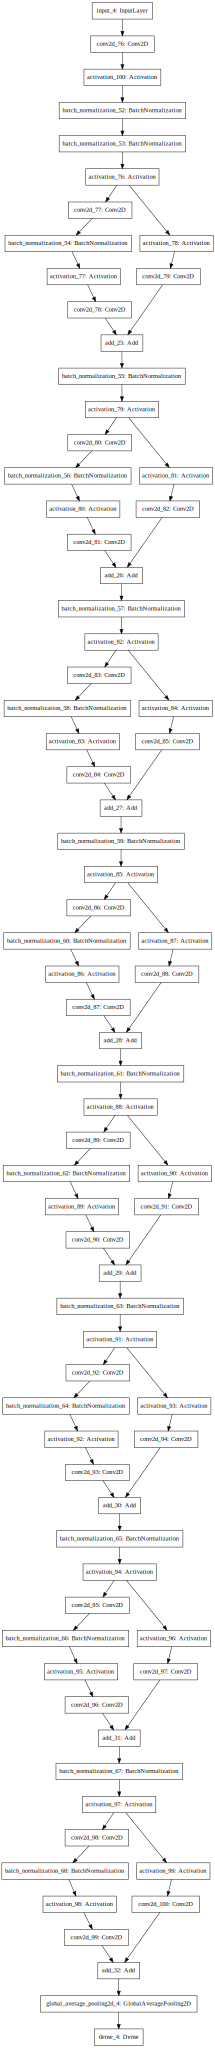

In [0]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(keras_model).create(prog='dot', format='svg'))